# <span style="color: steelblue;">Differential Gene expression(DGE) analysis using scaLR </span>

## <span style="color: steelblue;"> Keypoints </span>
- Differential gene expression (DGE) analysis is a method employed in genomics to evaluate and compare gene expression levels across different sample groups. This can include comparisons between healthy and diseased tissues or cells subjected to various treatments.

- In single-cell RNA-seq (scRNA-seq) data, the gene expression matrix is organized into various hierarchical groups. These groups may include regions from which samples were collected, clinical conditions such as different disease stages or normal states. For each individual subject in the study, RNA-seq generates a number of cells, with gene expression levels varying across different cell types.

- Major single-cell differential gene expression (scDGE) analysis approaches are Pseudobulk, Mixed-effects models, and Differential distribution based methods. This tutorial explains how to perform scDGE analysis using scaLR DGE module which includes: ```Pseudobulk``` and ```Linear mixed-effects model```approaches.

## <span style="color: steelblue;">Cloning scaLR</span>

In [1]:
!git clone -b sj/fullntest_samples_analysis https://github.com/infocusp/scaLR.git

Cloning into 'scaLR'...
remote: Enumerating objects: 3093, done.
remote: Counting objects: 100% (661/661), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 3093 (delta 391), reused 616 (delta 369), pack-reused 2432 (from 1)
Receiving objects: 100% (3093/3093), 166.83 MiB | 25.80 MiB/s, done.
Resolving deltas: 100% (1840/1840), done.


## <span style="color: steelblue;">Library Installation and Imports</span>

In [2]:
import sys
sys.path.append('/content/scaLR')

In [3]:
!pip install scanpy
!pip install shap
!pip install pydeseq2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.4 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=4225af4c51cd47356cb3f63df56da731637d5e57d967e4cab17bc51e6b6602ff
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 893.9 kB/s eta 0:00:00


In [5]:
import os
from IPython.display import SVG, display
from matplotlib_venn import venn2
import numpy as np
import pandas as pd
import scanpy as sc
from scalr.analysis import dge_lmem
from scalr.analysis import dge_pseudobulk
%reload_ext autoreload
%autoreload 2

## <span style="color: steelblue;">Downloading data</span>
- Downloading an anndata from `cellxgene` and making a subset anndata with 1000 genes for the downstream analysis.

In [6]:
# This shell will take approximately 00:00:24 (hh:mm:ss) to run.
!wget -P deg_data https://datasets.cellxgene.cziscience.com/16acb1d0-4108-4767-9615-0b42abe09992.h5ad
whole_adata = sc.read_h5ad('deg_data/16acb1d0-4108-4767-9615-0b42abe09992.h5ad',backed='r')
whole_adata[:,:1000].to_memory().write('deg_data/test_data.h5ad',compression='gzip')

--2024-10-23 07:21:15--  https://datasets.cellxgene.cziscience.com/16acb1d0-4108-4767-9615-0b42abe09992.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 18.160.200.112, 18.160.200.32, 18.160.200.93, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156074722 (149M) [binary/octet-stream]
Saving to: ‘deg_data/16acb1d0-4108-4767-9615-0b42abe09992.h5ad’

16acb1d0-4108-4767- 100%[===================>] 148.84M  13.9MB/s    in 11s     

2024-10-23 07:21:27 (13.5 MB/s) - ‘deg_data/16acb1d0-4108-4767-9615-0b42abe09992.h5ad’ saved [156074722/156074722]

Time taken (hh:mm:ss) : 00:00:24


## <span style="color: steelblue;">Loading of data and its exploration</span>

In [7]:
dirpath = 'deg_data'
adata = sc.read_h5ad(os.path.join(dirpath,'test_data.h5ad'),backed='r')

# # There might be negative count errors while performing 'DgePseudoBulk' if the sum of gene expression across donors
# # or subjects for a cell type is negative. This can occur due to usage of different normalization or batch-correction on gene expression
# # values in the 'X' matrix of the AnnData object. Therefore, it is recommended to use the raw gene expression values to perform 'DgePseudoBulk'.

# # An example to create anndata with raw gene expression values.
# test_anndata = sc.read_h5ad('path/to/original/anndata',backed='r')
# # To check the availibility of raw data, below code should return True.
# test_anndata.raw is not None

# # If the 'X' matrix is normalized, it ideally produces floating-point values for the sum of gene expression in each cell,
# # rather than the integer counts found in the raw matrix and can be checked like below.
# test_anndata.X[:5,:].A.sum(axis=1)
# test_anndata.raw.X[:5,:].A.sum(axis=1)

# #Prepare the raw anndata.
# test_anndata_raw = test_anndata.AnnData(X=test_anndata.raw.X,obs=test_anndata.obs,var=test_anndata.var)
# sc.write("/path/to/savefile/test_anndata_raw.h5ad",test_anndata_raw)

# # After saving the raw AnnData, it can be loaded into the variable 'adata'.
# adata = sc.read_h5ad('path/to/raw/adata',backed='r')

# # Linear mixed effects model(DgeLMEM) based analysis performes well if the data is normalized.
# # So it can use the original normalized 'X' matrix in the 'test_anndata'.

In [8]:
# Structure of the anndata.
adata

AnnData object with n_obs × n_vars = 20000 × 1000 backed at 'deg_data/test_data.h5ad'
    obs: 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'age(y)', 'sub_cluster', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'donor_BMI_at_collection', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'Unnamed: 0', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'Contacting Author', 'citation', 'data sources', 'schema_reference', 'schema_

In [9]:
# Cell barcodes and metadata.
adata.obs.head()

,Dataset,sample,disease_original,disease_general,COVID-19 Condition,Lineage,Cell.group,Cell.class,n_genes,n_counts,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
Arunachalam-cov01_AAACCCACACCAGCGT-1,Arunachalam_et al._Science,Arunachalam_cov01,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,COVID-19 Severe,Lymphoid_P,Plasmablast,Plasmablast,5427,31947.393,...,tissue,plasmablast,10x 3' v3,COVID-19,Homo sapiens,female,blood,European,75-year-old stage,rh@)hfhfXO
Arunachalam-cov01_AAACGCTGTAGCTTGT-1,Arunachalam_et al._Science,Arunachalam_cov01,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,COVID-19 Severe,Lymphoid_B,B cell,B memory,1850,14887.546,...,tissue,memory B cell,10x 3' v3,COVID-19,Homo sapiens,female,blood,European,75-year-old stage,hxQvvdBF?Z
Arunachalam-cov01_AAACGCTGTTTGACAC-1,Arunachalam_et al._Science,Arunachalam_cov01,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,COVID-19 Severe,Lymphoid_P,Plasmablast,Plasmablast,5905,32865.180,...,tissue,plasmablast,10x 3' v3,COVID-19,Homo sapiens,female,blood,European,75-year-old stage,tNh-$W7993
Arunachalam-cov01_AAAGGGCAGCTTGTGT-1,Arunachalam_et al._Science,Arunachalam_cov01,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,COVID-19 Severe,Lymphoid_P,Plasmablast,Plasmablast,1845,15425.812,...,tissue,plasmablast,10x 3' v3,COVID-19,Homo sapiens,female,blood,European,75-year-old stage,8MJGw*Nv2q
Arunachalam-cov01_AAAGGGCTCGAATCCA-1,Arunachalam_et al._Science,Arunachalam_cov01,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,COVID-19 Severe,Lymphoid_B,B cell,B naive,1473,12440.458,...,tissue,naive B cell,10x 3' v3,COVID-19,Homo sapiens,female,blood,European,75-year-old stage,6N!_X0h-)5


In [10]:
# Gene information metadata.
adata.var.head()

,n_cells,Unnamed: 0,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000118271,0,48379.0,False,TTR,NCBITaxon:9606,gene,640,protein_coding
ENSG00000130684,453,15210.0,False,ZNF337,NCBITaxon:9606,gene,3613,protein_coding
ENSG00000137726,10,9611.0,False,FXYD6,NCBITaxon:9606,gene,669,protein_coding
ENSG00000025772,1409,15342.0,False,TOMM34,NCBITaxon:9606,gene,1973,protein_coding
ENSG00000115183,57,2522.0,False,TANC1,NCBITaxon:9606,gene,4351,protein_coding


In [11]:
# Information about subjects.
adata.obs.donor_id.unique()

['cov01', 'cov02', 'cov03', 'cov04', 'cov07', ..., 'C3', 'C4', 'C5', 'C6', 'C7']
Length: 63
Categories (63, object): ['C1', 'C19-CB-0001', 'C19-CB-0002', 'C19-CB-0003', ..., 'nCoV 6',
                          'nCoV 7_8', 'nCoV 9_10', 'one_Ten']

In [12]:
# Celltype information.
adata.obs.cell_type.value_counts()

,count
cell_type,
naive B cell,8998
transitional stage B cell,3830
plasmablast,2801
memory B cell,2756
IgG plasmablast,921
IgA plasmablast,694


In [13]:
# Clinical conditions.
adata.obs.disease.value_counts()

,count
disease,
COVID-19,13888
normal,6112


## <span style="color: steelblue;">DGE analysis using Pseudobulk approach</span>

- ```Pseudobulk``` approach involves aggregating the unique molecular identifier (UMI) counts within each cell type of all
  subjects, effectively creating a "pseudobulk" dataset.
- In this method, the scRNA-seq data is summarized to resemble bulk RNA-seq data, where the UMI counts from all cells
  of a specific type are combined for each subject.
- This aggregated dataset can then be analyzed using DGE methods designed for bulk RNA-seq by treating each
  cell type's UMI counts as if they were from a bulk sample.

### <span style="color: steelblue;">Analysis</span>

- The analysis starts by selecting a subset of ```cell types``` for the differential gene expression (DGE) analysis, followed by
  extracting individual subsets of the `AnnData` object for each cell type.
- The ```donor_id``` in ```adata.obs``` will be used to identify the subjects, while the ```disease``` column will serve as the
  ```design_factor```, with `['COVID-19', 'normal']` representing the two factor levels for the ```design_factor```.
- The required and optionalparameters are outlined below.

In [38]:
dge_pbk = dge_pseudobulk.DgePseudoBulk(celltype_column = 'cell_type',
                                       design_factor = 'disease',
                                       factor_categories = ['COVID-19', 'normal'],
                                       sum_column = 'donor_id',
                                       cell_subsets = ['plasmablast','memory B cell'],
                                       min_cell_threshold = 1,
                                       fold_change = 1.5,
                                       p_val = 0.05,
                                       y_lim_tuple = None,
                                       save_plot = True,
                                       stdout = True)

#### <span style="color: steelblue;">Parameters </span>
- (* marked are required)
   
    - ```*celltype_column``` : Column name in `anndata.obs` containing all the cell types
    - ```*design_factor``` : Column name in `anndata.obs` containing different factor levels or categories for differential gene expression analysis           
    - ```*factor_categories``` : List of conditions in ```design_factor``` used to create the design matrix, with the last category in the list serving as the reference to the first. For example, in ```['disease_1','normal']```, ```normal``` serves as the reference.
    - ```*sum_column``` : Column name to sum values across samples.  
    - ```*cell_subsets``` : Selcted list of cell types in ```celltype_column``` to subset the anndata.
    - ```min_cell_threshold``` : Minimum number of subjects with aggregated nonzero gene expression values.
      Each subject has the aggregated expression value for each gene of the selected cell type.
      If `min_cell_threshold = 1` is specified, genes will be filtered out unless they have at least one non-zero value in the subjects.
    - ```fold_change``` : Fold change to filter the differentially expressed genes for volcano plot.
    - ```p_val``` : ```p```value to filter differentially expressed genes for volcano plot.
    - ```y_lim_tuple``` : Values to adjust the Y-axis limits of the plot.
    - ```save_plot``` : Boolean value to save the plot.
    - ```stdout``` : Boolean value to print logs to stdout

In [16]:
# Generate analysis and save the result.
# This shell will take approximately 00:00:16 (hh:mm:ss) to run.
dge_pbk.generate_analysis(adata,dirpath)


----- DGE analysis using Pseudobulk -----


Processing for "plasmablast" ...
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np

Log2 fold change & Wald test p-value: disease COVID-19 vs normal
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000130684   2.402739        0.665687  0.695964  0.956498  0.338821   
ENSG00000137726   0.006672       -2.499973  3.411714 -0.732762  0.463704   
ENSG00000025772  12.971955        1.790866  0.459287  3.899231  0.000096   
ENSG00000115183   1.736014        1.133197  1.251871  0.905203  0.365358   
ENSG00000166140  11.114531       -0.828455  0.497441 -1.665435  0.095826   
...                    ...             ...       ...       ...       ...   
ENSG00000112584   6.111353        0.278761  0.519683  0.536406  0.591678   
ENSG00000132793   0.486535        0.122005  1.490330  0.081864  0.934755   
ENSG00000184788   0.050180       -1.829216  2.733583 -0.669164  0.503391   
ENSG00000138080   0.150355       -1.049227  1.936959 -0.541687  0.588034   
ENSG00000156453   0.027238       -2.121537  3.398120 -0.624327  0.532413   

                     p


Processing for "memory B cell" ...
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warning

Log2 fold change & Wald test p-value: disease COVID-19 vs normal
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000130684   7.060173        0.437477  0.718891  0.608544  0.542827   
ENSG00000137726   0.027539        1.085172  3.363430  0.322638  0.746969   
ENSG00000025772  13.554159        0.064236  0.478891  0.134136  0.893295   
ENSG00000115183   0.348535        0.820773  3.119576  0.263104  0.792470   
ENSG00000166140  10.310136        0.225320  0.528405  0.426416  0.669805   
...                    ...             ...       ...       ...       ...   
ENSG00000184788   0.152795       -0.090652  3.274791 -0.027682  0.977916   
ENSG00000138080   0.217979        0.015361  3.264463  0.004706  0.996245   
ENSG00000185483   0.233577       -1.150438  3.258457 -0.353062  0.724042   
ENSG00000205041   0.403206       -0.617965  3.247317 -0.190300  0.849074   
ENSG00000133475   0.220077        1.736939  3.347748  0.518838  0.603874   

                     p


Pseudobulk-DGE results stored at: deg_data/pseudobulk_dge_result



Time taken (hh:mm:ss) : 00:00:16


### <span style="color: steelblue;">Result</span>

In [17]:
# Pseudobulk(pbk).
pbk_result_plb = pd.read_csv(f'{dirpath}/pseudobulk_dge_result/pbkDGE_plasmablast_COVID-19_vs_normal.csv')
pbk_result_plb.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000130684,2.402739,0.665687,0.695964,0.956498,0.338821,0.664478
1,ENSG00000137726,0.006672,-2.499973,3.411714,-0.732762,0.463704,NaN
2,ENSG00000025772,12.971955,1.790866,0.459287,3.899231,0.000096,0.005597
3,ENSG00000115183,1.736014,1.133197,1.251871,0.905203,0.365358,0.676355
4,ENSG00000166140,11.114531,-0.828455,0.497441,-1.665435,0.095826,0.370527


- DGE results for each gene in ```plasmablast```
    - ```gene``` - Gene name
    -  ```baseMean``` - Mean gene expression
    - ```log2FoldChange``` : log2 fold change in gene expression in ```COVID-19``` compared to ```normal``` subjects
    - ```lfcSE``` : Standard Error for log2 fold change
    - ```stat``` : ```Wald's test``` statistics
    - ```pvalue``` : ```p``` value
    - ```padj``` : Adjusted ```p``` value
  

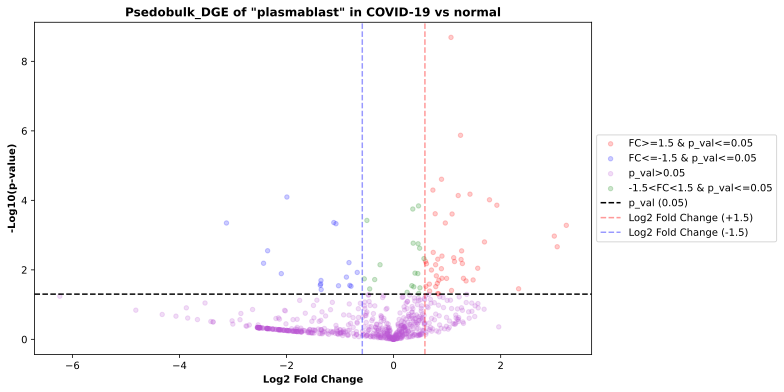

In [18]:
# Volcano plot of `log2FoldChange` vs `-log10(pvalue)` in gene expression in `plasmablast`.
display(SVG('deg_data/pseudobulk_dge_result/pbkDGE_plasmablast_COVID-19_vs_normal.svg'))

## <span style="color: steelblue;">DGE analysis using Linear Mixed Effects Model (LMEM) approach </span>

- A linear mixed-effects model can incorporate both fixed and random effects. Fixed effects remain consistent across the population, while random effects vary across different groups or levels within the data and are modeled as random variables with their distribution, typically assumed to follow a normal distribution.
- In scRNA-seq data, these effects allow the model to treat certain parameters as random variables at the subject level, while fixing others at a higher level, such as the population mean for a clinical condition.
- In the same dataset, we will explore both fixed and random effects parameters and conduct differential gene expression analysis, taking these effects into account.

### <span style="color: steelblue;">Analysis</span>

- We'll select a subset of cell types for the differential gene expression (DGE) analysis.
- Next, we'll subset the ```AnnData``` object for each cell type individually.
- The final linear mixed-effects model (LMEM) analysis will use the ```disease``` column as the ```fixed effect``` parameter and ```donor_id``` as the ```random effect``` or ```group``` parameter. The required and optional parameters are listed below.

In [19]:
dge_lm = dge_lmem.DgeLMEM(fixed_effect_column = 'disease',
                          fixed_effect_factors = ['COVID-19', 'normal'],
                          group = 'donor_id',
                          celltype_column = 'cell_type',
                          cell_subsets = ['plasmablast'],
                          min_cell_threshold = 10,
                          n_cpu = 6,
                          gene_batch_size = 1000,
                          coef_threshold = 0,
                          p_val = 0.05,
                          save_plot = True,
                          stdout = True)

#### <span style="color: steelblue;">Parameters </span>
- (* marked are required)
   
    - *```fixed_effect_column``` : Column name in ```anndata.obs``` containing different factor levels or categories for
      differential gene expression analysis. This serves as the ```fixed_effect``` parameter.           
    - *```fixed_effect_factors``` : List of conditions in ```fixed_effect_column``` used to create the design matrix, with the last
      category in the list serving as the reference to others. For example, in ```['disease_1','disease_2','normal']```,
      ```normal``` serves as the reference.
    - *```group``` : Column name to act as a ```random_effect``` parameter for mixed effect model.
    - *```celltype_column``` : Column name in ```anndata.obs``` containing all the cell types. Analysis can be done without this
      parameter, i.e. without susetting the input data as per the celltypes, but it is better to fix the data with a particular
      celltype to remove the cell specific confounding effects.  
    - *```cell_subsets``` : Selcted list of cell types in ```celltype_column``` to subset the anndata.
    - ```min_cell_threshold``` : Minimum number of cells with nonzero values for a gene.
    - ```n_cpu``` : Number of CPUs for parallelization.
    - ```gene_batch_size``` : Number of genes in a batch of processing.
    - ```coef_threshold``` : Threshold to filter up and down regulated genes in volcano plot.
    - ```p_val``` : ```p```value to filter differentially expressed genes for volcano plot.
    - ```y_lim_tuple``` : Values to adjust the Y-axis limits of the plot.
    - ```save_plot``` : Boolean value to save the plot.
    - ```stdout``` : Boolean value to print logs to stdout

In [20]:
# Linear mixed-effects model analysis is computationally intensive and typically parallelized across multiple CPU cores for efficiency.
# It may take a bit more time, as the multiprocessing is not very efficient with only 2 CPUs in the current Colab runtime.
# This shell will take approximately 00:04:27 (hh:mm:ss) to run.

# Generate analysis and save the result.
dge_lm.generate_analysis(adata,dirpath)


----- DGE analysis using LMEM -----

Performing DGE analysis with subset anndata

Processing for "plasmablast" ...
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

LMEM-DGE results stored at: deg_data/lmem_dge_result



Time taken (hh:mm:ss) : 00:04:27


### <span style="color: steelblue;">Result</span>

In [21]:
# LMEM(lmem).
lmem_result_plb = pd.read_csv(f'{dirpath}/lmem_dge_result/lmemDGE_plasmablast.csv')
lmem_result_plb.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19
0,ENSG00000130684,0.077299,0.113387,0.495409,0.681731,0.760120
1,ENSG00000025772,0.735955,0.270583,0.006530,2.719885,0.134523
2,ENSG00000115183,0.082861,0.077784,0.286757,1.065262,0.617237
3,ENSG00000166140,-0.274577,0.193808,0.156557,-1.416746,0.496731
4,ENSG00000104522,0.176228,0.514578,0.731997,0.342471,0.919918


- Model results for each gene in ```plasmablast```
    - ```gene``` - Gene name
    - ```coef_COVID-19``` : Coefficient difference of ```COVID-19``` subjects compared to ```normal``` ones
    - ```SEcoef_COVID-19``` : Coefficient Standard Error
    - ```pval_COVID-19``` : ```p``` value
    - ```stat_COVID-19``` : ```Wald's test``` statistics
    - ```adj_pval_COVID-19``` : Adjusted ```p``` value
  

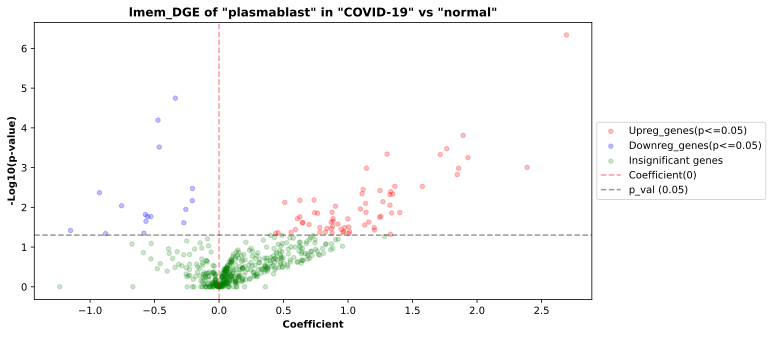

In [ ]:
# Volcano plot of `coef_COVID-19` vs `-log10(pval_COVID-19)` in `plasmablast`.
display(SVG(f'{dirpath}/lmem_dge_result/lmem_DGE_plasmablast_COVID-19.svg'))

## <span style="color: steelblue;">DGE analysis for large Anndata with Nohang Up</span>

- For running the ```DgePseudoBulk/DgeLMEM``` analysis as a Python script, clone and install [scaLR](https://github.com/infocusp/scaLR) in the machine.
- Move to the ```tutorials/analysis/differential_gene_expression/``` directory.
  In ```dge_config.yaml```, update the ```dge_type``` and ```psedobulk/lmem_params```.
- ```dirpath``` and ```full_datapath``` represent the paths to save the results and the AnnData file, respectively.

- ```dge_config.yaml``` for ```DgePseudoBulk/DgeLMEM```

     ![Alt text](https://github.com/infocusp/scaLR/blob/main/tutorials/analysis/differential_gene_expression/tutorial_config.png?raw=1)

- In the terminal, type the following command after updating the ```/path/to/scaLR``` repository.
    - ```export PYTHONPATH="${PYTHONPATH}:/path/to/scaLR"```

- Run either of the commands below in the terminal as per the ```dge_type``` and ```parameters```:
    - ```nohup /usr/bin/time --verbose python -u dge_pseudobulk_main.py --config dge_config.yaml >nohup_dge_pbk 2>&1 &```
    - ```nohup /usr/bin/time --verbose python -u dge_lmem_main.py --config dge_config.yaml >nohup_dge_lmem 2>&1 &```

## <span style="color: steelblue;">Comparison of identified up- and down- regulated genes by Pseudobulk and LMEM approaches in plasmablast</span>

In [22]:
# Pseudobulk result for 'plasmablast'.
pbk_result_plb.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000130684,2.402739,0.665687,0.695964,0.956498,0.338821,0.664478
1,ENSG00000137726,0.006672,-2.499973,3.411714,-0.732762,0.463704,NaN
2,ENSG00000025772,12.971955,1.790866,0.459287,3.899231,0.000096,0.005597
3,ENSG00000115183,1.736014,1.133197,1.251871,0.905203,0.365358,0.676355
4,ENSG00000166140,11.114531,-0.828455,0.497441,-1.665435,0.095826,0.370527


In [23]:
# LMEM result for 'plasmablast'.
lmem_result_plb.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19
0,ENSG00000130684,0.077299,0.113387,0.495409,0.681731,0.760120
1,ENSG00000025772,0.735955,0.270583,0.006530,2.719885,0.134523
2,ENSG00000115183,0.082861,0.077784,0.286757,1.065262,0.617237
3,ENSG00000166140,-0.274577,0.193808,0.156557,-1.416746,0.496731
4,ENSG00000104522,0.176228,0.514578,0.731997,0.342471,0.919918


In [24]:
# Adding column with absolute values for 'log2FoldChange' and 'coef_COVID-19' in the dataframes.
pbk_result_plb['abs_log2FoldChange'] = np.abs(pbk_result_plb['log2FoldChange'])
lmem_result_plb['abs_coef_COVID-19'] = np.abs(lmem_result_plb['coef_COVID-19'])

In [25]:
pbk_result_plb.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_log2FoldChange
0,ENSG00000130684,2.402739,0.665687,0.695964,0.956498,0.338821,0.664478,0.665687
1,ENSG00000137726,0.006672,-2.499973,3.411714,-0.732762,0.463704,NaN,2.499973
2,ENSG00000025772,12.971955,1.790866,0.459287,3.899231,0.000096,0.005597,1.790866
3,ENSG00000115183,1.736014,1.133197,1.251871,0.905203,0.365358,0.676355,1.133197
4,ENSG00000166140,11.114531,-0.828455,0.497441,-1.665435,0.095826,0.370527,0.828455


In [26]:
lmem_result_plb.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19,abs_coef_COVID-19
0,ENSG00000130684,0.077299,0.113387,0.495409,0.681731,0.760120,0.077299
1,ENSG00000025772,0.735955,0.270583,0.006530,2.719885,0.134523,0.735955
2,ENSG00000115183,0.082861,0.077784,0.286757,1.065262,0.617237,0.082861
3,ENSG00000166140,-0.274577,0.193808,0.156557,-1.416746,0.496731,0.274577
4,ENSG00000104522,0.176228,0.514578,0.731997,0.342471,0.919918,0.176228


In [27]:
# Setting required parameters to filter the up and down-regulated genes.
fold_change = 1.5
log2_fc = np.log2(fold_change)
p_val = 0.05
coef_threshold = 0

In [28]:
# Getting stats for up and down regulated genes in Pseudobulk result.
pbk_up_reg_gene_df = pbk_result_plb.loc[(pbk_result_plb['log2FoldChange']>=log2_fc)&(pbk_result_plb['pvalue']<=p_val)]
pbk_up_reg_gene_df = pbk_up_reg_gene_df.sort_values(by='abs_log2FoldChange',ascending=False)
pbk_down_reg_gene_df = pbk_result_plb.loc[(pbk_result_plb['log2FoldChange']<=(-log2_fc))&(pbk_result_plb['pvalue']<=p_val)]
pbk_down_reg_gene_df = pbk_down_reg_gene_df.sort_values(by='abs_log2FoldChange',ascending=False)

In [29]:
pbk_up_reg_gene_df.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_log2FoldChange
464,ENSG00000274213,4.852268,3.225761,0.930090,3.468226,0.000524,0.012794,3.225761
189,ENSG00000137965,17.887057,3.055486,0.996517,3.066164,0.002168,0.041919,3.055486
424,ENSG00000211959,5.274993,3.001469,0.917370,3.271818,0.001069,0.024791,3.001469
32,ENSG00000185305,3.173841,2.334678,1.108162,2.106802,0.035135,0.225042,2.334678
432,ENSG00000129566,11.167719,1.928940,0.506046,3.811788,0.000138,0.006719,1.928940


In [31]:
pbk_down_reg_gene_df.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_log2FoldChange
661,ENSG00000071282,3.913610,-3.122193,0.889585,-3.509719,0.000449,0.012146,3.122193
138,ENSG00000260898,4.058761,-2.429289,0.891975,-2.723495,0.006460,0.079221,2.429289
301,ENSG00000196110,3.587681,-2.353140,0.788041,-2.986062,0.002826,0.048958,2.353140
618,ENSG00000158079,1.676030,-2.097836,0.843205,-2.487932,0.012849,0.124205,2.097836
470,ENSG00000137166,6.316397,-1.993201,0.505436,-3.943528,0.000080,0.005322,1.993201


In [32]:
# Getting stats for up and down regulated genes in LMEM result.
lmem_up_reg_gene_df = lmem_result_plb.loc[(lmem_result_plb['coef_COVID-19']>coef_threshold)&(lmem_result_plb['pval_COVID-19']<=p_val)]
lmem_up_reg_gene_df = lmem_up_reg_gene_df.sort_values(by='abs_coef_COVID-19',ascending=False)
lmem_down_reg_gene_df = lmem_result_plb.loc[(lmem_result_plb['coef_COVID-19']<(-coef_threshold))&(lmem_result_plb['pval_COVID-19']<=p_val)]
lmem_down_reg_gene_df = lmem_down_reg_gene_df.sort_values(by='abs_coef_COVID-19',ascending=False)

In [33]:
lmem_up_reg_gene_df.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19,abs_coef_COVID-19
488,ENSG00000138760,2.693445,0.534133,4.591339e-07,5.042648,0.000236,2.693445
398,ENSG00000118971,2.388309,0.725031,9.874572e-04,3.294076,0.044476,2.388309
49,ENSG00000184260,1.928825,0.558966,5.591369e-04,3.450699,0.031933,1.928825
284,ENSG00000163463,1.892143,0.500117,1.546986e-04,3.783403,0.019879,1.892143
483,ENSG00000185608,1.856866,0.565882,1.033058e-03,3.281365,0.044476,1.856866


In [35]:
lmem_down_reg_gene_df.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19,abs_coef_COVID-19
155,ENSG00000204287,-1.151499,0.556057,0.038375,-2.070830,0.281780,1.151499
88,ENSG00000171425,-0.927406,0.324591,0.004275,-2.857149,0.106712,0.927406
472,ENSG00000100290,-0.880190,0.440646,0.045771,-1.997499,0.286906,0.880190
225,ENSG00000182534,-0.755743,0.289854,0.009125,-2.607327,0.150311,0.755743
129,ENSG00000158234,-0.582763,0.290360,0.044746,-2.007039,0.286906,0.582763


### <span style="color: steelblue;">Common up-regulated genes identified Pseudobulk v/s LMEM approaches</span>

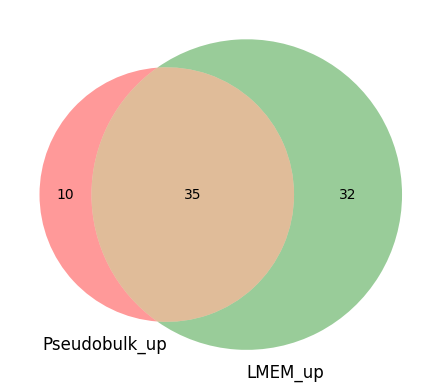

In [36]:
venn2([set(pbk_up_reg_gene_df['gene']), set(lmem_up_reg_gene_df['gene'])], set_labels=('Pseudobulk_up', 'LMEM_up'))

### <span style="color: steelblue;">Common down-regulated genes identified Pseudobulk v/s LMEM approaches</span>

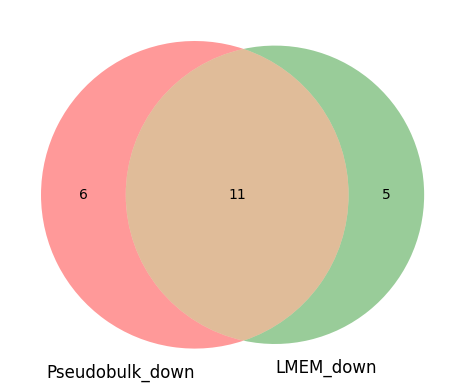

In [37]:
venn2([set(pbk_down_reg_gene_df['gene']), set(lmem_down_reg_gene_df['gene'])], set_labels=('Pseudobulk_down', 'LMEM_down'))